In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import importlib

import numpy as np
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

In [2]:
#download the ECCO grid file

from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                    StartDate="2000-01-09",EndDate="2000-01-14",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2000-01-09,2000-01-14'}

Total number of matching granules: 1

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|########################| 1/1 [00:00<00:00, 11618.57it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


In [3]:
# download file (granule) containing 2000 velocities,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vel_monthly_shortname,\
                    StartDate="2000-01-02",EndDate="2000-12-31",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2000-01-02,2000-12-31'}

Total number of matching granules: 12

OCEAN_VELOCITY_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-03_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-04_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-02_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-05_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-06_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-07_ECCO_V4r4_native_llc0090.nc already exist

In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [7]:
## Load vector fields
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*OCEAN*VEL*MONTHLY*','*_2000-*.nc'))

ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars)).load()

In [8]:
horizontal_speed_over_depth_layers_interpolated = {}

In [9]:
# here we get the old horizontal speed
lon = np.linspace(-72,-67,6)
lat = np.linspace(34,39,6)
lon2d, lat2d = np.meshgrid(lon, lat)
lon_new = np.linspace(-72,-67,60)
lat_new = np.linspace(34,39,60)

for depth in range(0,20):
    speed = np.zeros((6, 6))
    
    xfld = ecco_ds.UVEL.isel(k=depth, time=0)
    yfld = ecco_ds.VVEL.isel(k=depth, time=0)
    # Compute the zonal and meridional vector components of UVEL and VVEL
    VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)   
    
    for i in range(0,6):
        for j in range(0,6):
            delta_lat = 1
            delta_lon = 1
            new_grid_min_lat = 34-1.5 + j
            new_grid_max_lat = 34+0.5 + j

            new_grid_min_lon = -72-1.5 + i
            new_grid_max_lon = -72+0.5 + i
            # interpolate to lat-lon
            new_grid_lon_centers, new_grid_lat_centers,\
            new_grid_lon_edges, new_grid_lat_edges,\
            UVEL_latlon =\
                ecco.resample_to_latlon(ecco_ds.XC, \
                                    ecco_ds.YC, \
                                    VEL_E,\
                                    new_grid_min_lat, new_grid_max_lat, delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, delta_lat,\
                                    fill_value = np.NaN, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
    
            new_grid_lon_centers, new_grid_lat_centers,\
            new_grid_lon_edges, new_grid_lat_edges,\
            VVEL_latlon =\
                ecco.resample_to_latlon(ecco_ds.XC, \
                                    ecco_ds.YC, \
                                    VEL_N,\
                                    new_grid_min_lat, new_grid_max_lat, delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, delta_lat,\
                                    fill_value = np.NaN, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
            speed_value = np.sqrt(UVEL_latlon[1,1]**2 + VVEL_latlon[1,1]**2)
            speed[i,j] = speed_value      
    #cubic interpolation        
    interpolation_function = interpolate.interp2d(lon2d, lat2d,speed,kind='cubic')        
    horizontal_speed_over_depth_layers_interpolated[depth] = interpolation_function(lon_new, lat_new)

In [10]:
dep = np.array(ecco_grid.Z[0:20])

<Figure size 640x480 with 0 Axes>

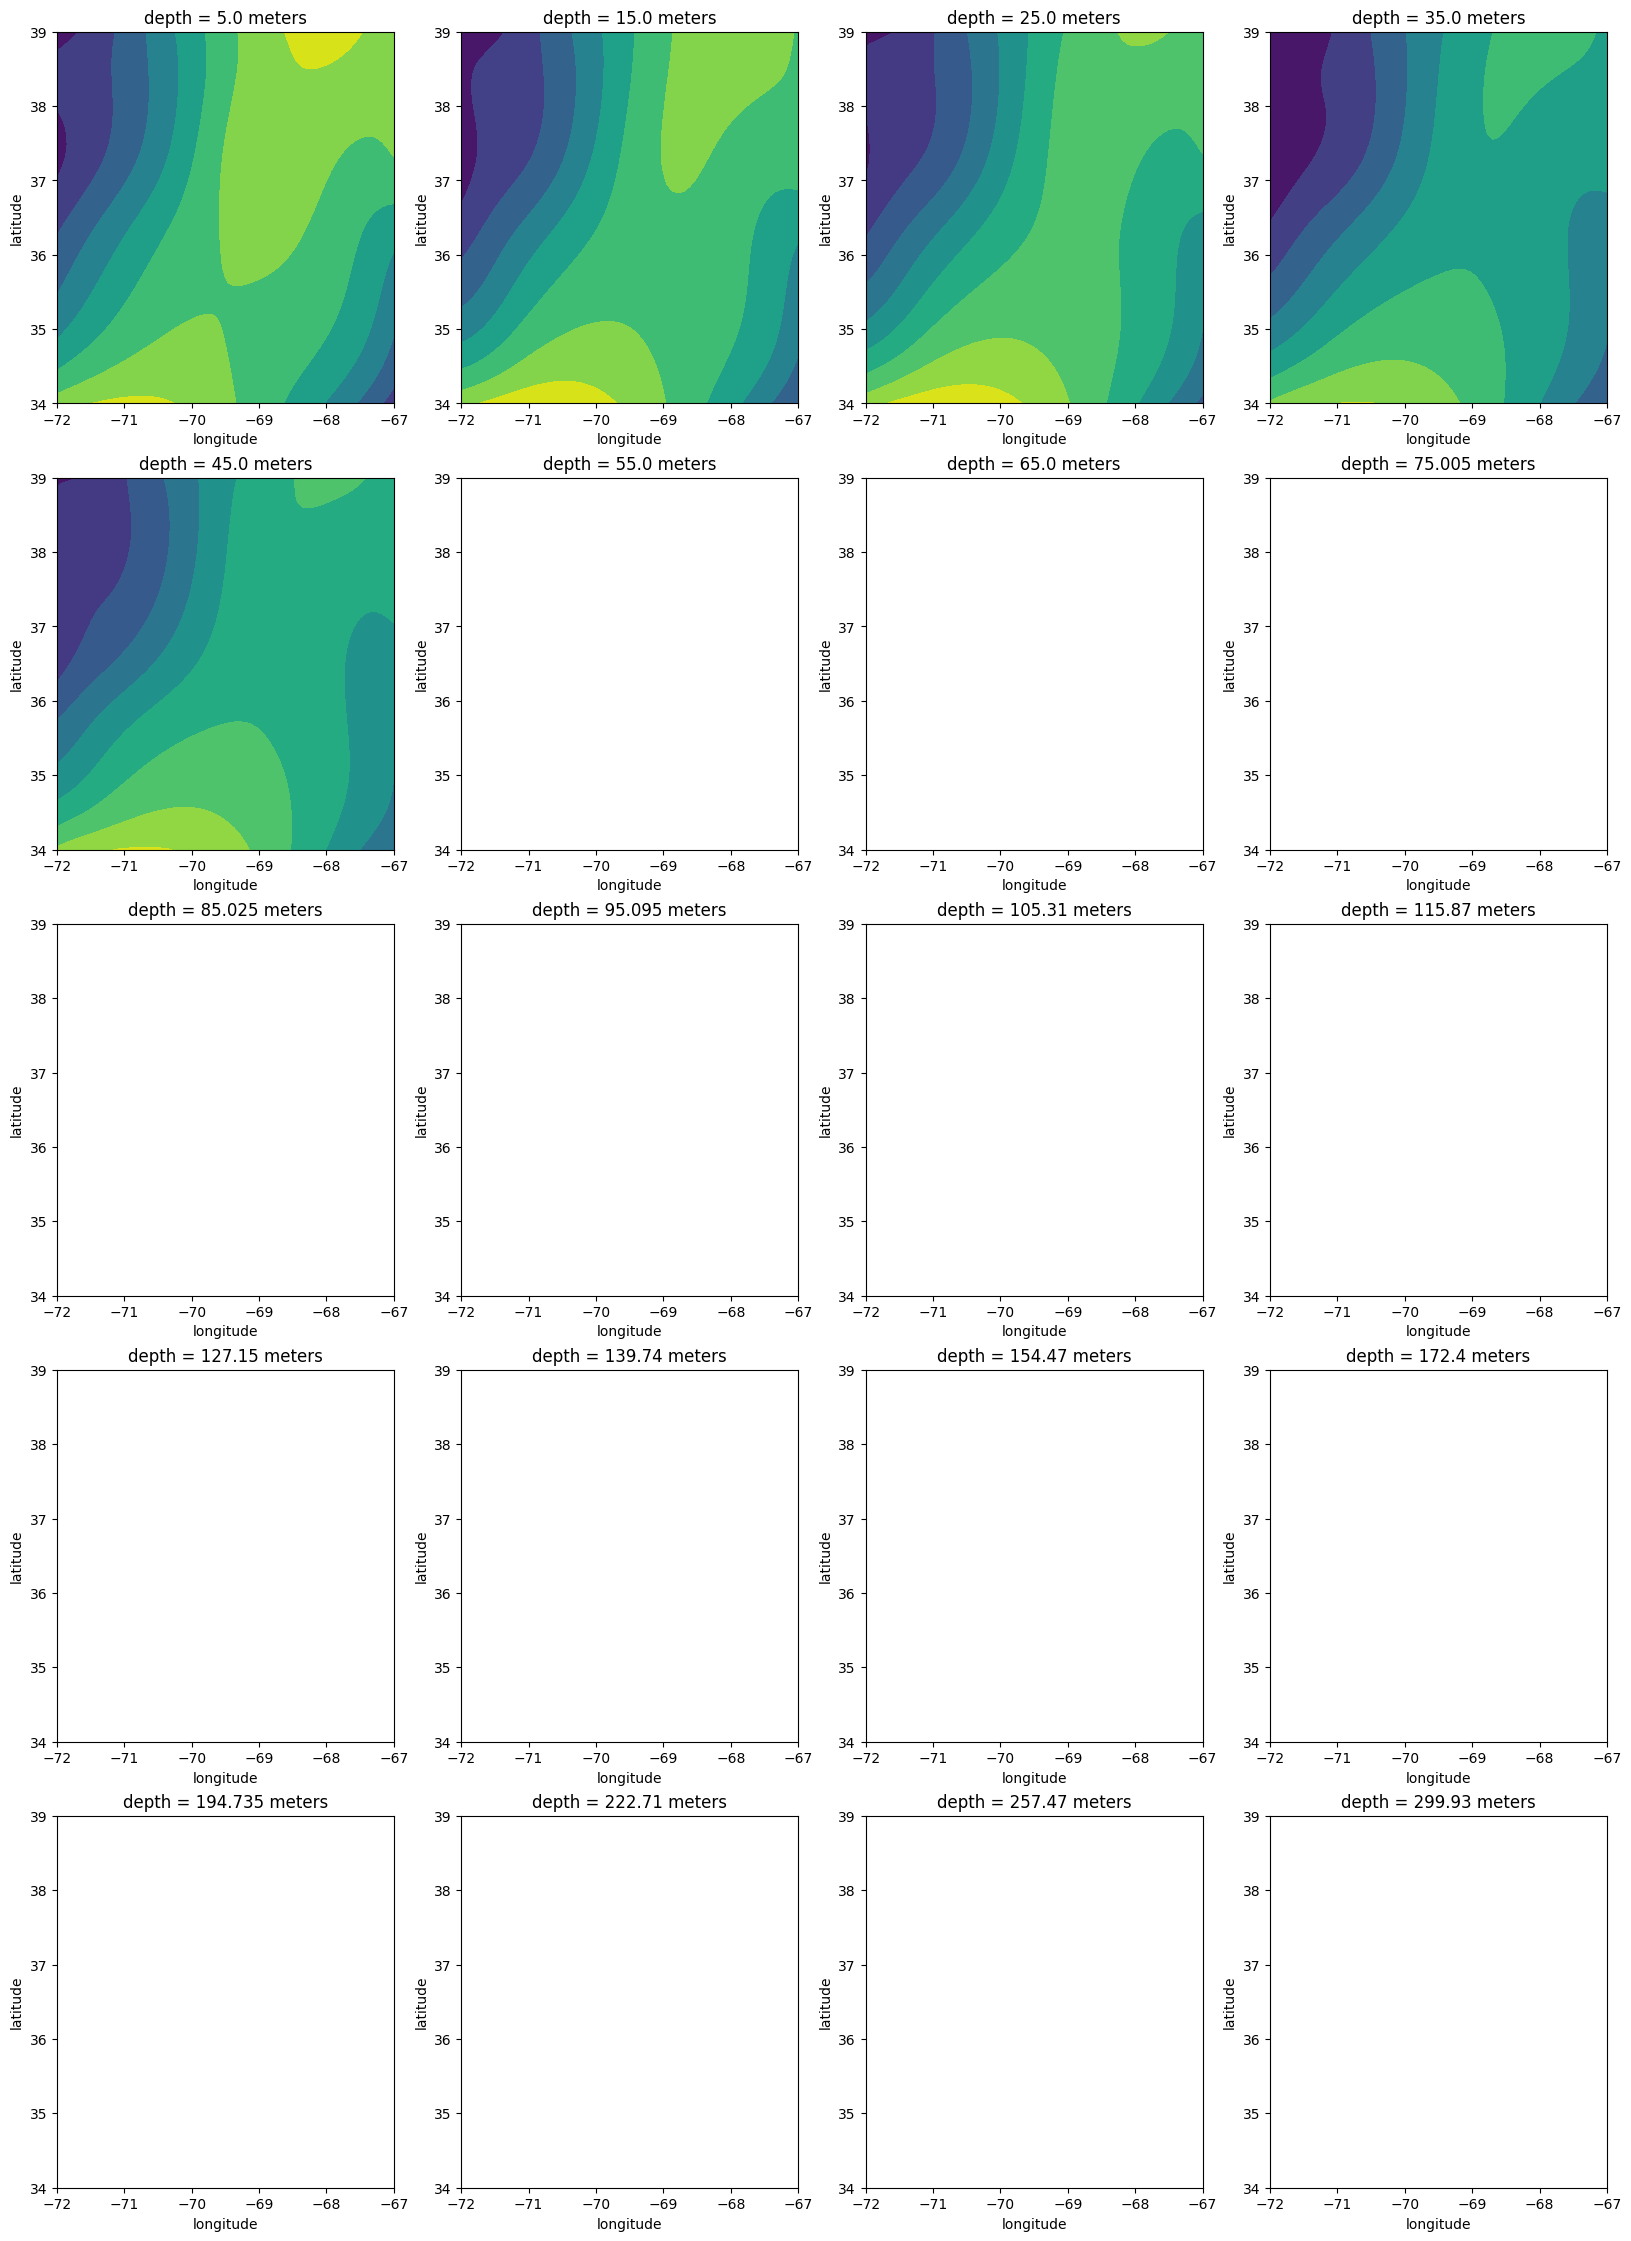

In [11]:
#plot horizontal speed profile
plt.figure()
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20,28))

ax[0,0].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[0])
ax[0,0].set_title('depth = ' + str(-dep[0]) + ' meters')
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')

ax[0,1].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[1])
ax[0,1].set_title('depth = ' + str(-dep[1]) + ' meters')
ax[0,1].set_xlabel('longitude')
ax[0,1].set_ylabel('latitude')

ax[0,2].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[2])
ax[0,2].set_title('depth = ' + str(-dep[2]) + ' meters')
ax[0,2].set_xlabel('longitude')
ax[0,2].set_ylabel('latitude')

ax[0,3].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[3])
ax[0,3].set_title('depth = ' + str(-dep[3]) + ' meters')
ax[0,3].set_xlabel('longitude')
ax[0,3].set_ylabel('latitude')

ax[1,0].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[4])
ax[1,0].set_title('depth = ' + str(-dep[4]) + ' meters')
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('latitude')

ax[1,1].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[5])
ax[1,1].set_title('depth = ' + str(-dep[5]) + ' meters')
ax[1,1].set_xlabel('longitude')
ax[1,1].set_ylabel('latitude')

ax[1,2].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[6])
ax[1,2].set_title('depth = ' + str(-dep[6]) + ' meters')
ax[1,2].set_xlabel('longitude')
ax[1,2].set_ylabel('latitude')

ax[1,3].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[7])
ax[1,3].set_title('depth = ' + str(-dep[7]) + ' meters')
ax[1,3].set_xlabel('longitude')
ax[1,3].set_ylabel('latitude')

ax[2,0].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[8])
ax[2,0].set_title('depth = ' + str(-dep[8]) + ' meters')
ax[2,0].set_xlabel('longitude')
ax[2,0].set_ylabel('latitude')

ax[2,1].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[9])
ax[2,1].set_title('depth = ' + str(-dep[9]) + ' meters')
ax[2,1].set_xlabel('longitude')
ax[2,1].set_ylabel('latitude')

ax[2,2].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[10])
ax[2,2].set_title('depth = ' + str(-dep[10]) + ' meters')
ax[2,2].set_xlabel('longitude')
ax[2,2].set_ylabel('latitude')

ax[2,3].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[11])
ax[2,3].set_title('depth = ' + str(-dep[11]) + ' meters')
ax[2,3].set_xlabel('longitude')
ax[2,3].set_ylabel('latitude')

ax[3,0].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[12])
ax[3,0].set_title('depth = ' + str(-dep[12]) + ' meters')
ax[3,0].set_xlabel('longitude')
ax[3,0].set_ylabel('latitude')

ax[3,1].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[13])
ax[3,1].set_title('depth = ' + str(-dep[13]) + ' meters')
ax[3,1].set_xlabel('longitude')
ax[3,1].set_ylabel('latitude')

ax[3,2].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[14])
ax[3,2].set_title('depth = ' + str(-dep[14]) + ' meters')
ax[3,2].set_xlabel('longitude')
ax[3,2].set_ylabel('latitude')

ax[3,3].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[15])
ax[3,3].set_title('depth = ' + str(-dep[15]) + ' meters')
ax[3,3].set_xlabel('longitude')
ax[3,3].set_ylabel('latitude')

ax[4,0].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[16])
ax[4,0].set_title('depth = ' + str(-dep[16]) + ' meters')
ax[4,0].set_xlabel('longitude')
ax[4,0].set_ylabel('latitude')

ax[4,1].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[17])
ax[4,1].set_title('depth = ' + str(-dep[17]) + ' meters')
ax[4,1].set_xlabel('longitude')
ax[4,1].set_ylabel('latitude')

ax[4,2].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[18])
ax[4,2].set_title('depth = ' + str(-dep[18]) + ' meters')
ax[4,2].set_xlabel('longitude')
ax[4,2].set_ylabel('latitude')

ax[4,3].contourf(lon_new, lat_new, horizontal_speed_over_depth_layers_interpolated[19])
ax[4,3].set_title('depth = ' + str(-dep[19]) + ' meters')
ax[4,3].set_xlabel('longitude')
ax[4,3].set_ylabel('latitude')

plt.savefig('myfile.png')

In [12]:
#now horizontal_speed_over_depth_layers_interpolated is a lat_new by lon_new by dep_new 3D array

In [13]:
#next we do interpolation using depth and longitude (keep latitude constant)
#note that there are 60 latitude values

#also note that horizontal_speed_over_depth_layers_interpolated[k][i,j] gives the speed at depth k, lon i, lat j.

# store new vertical interpolation values
vertical_speed_over_latitude_layers_interpolated = {}

In [14]:
dep = np.array(-ecco_grid.Z[0:20])
dep_new = np.linspace(dep[0], dep[19], 60)
lon2d, dep2d = np.meshgrid(lon, dep)
lon_new = np.linspace(-72,-67,20)

In [15]:
for lat_index in range(0,6):
    #speed is lon by dep array
    speed = np.zeros((6, 20))
    
    for i in range(0,20):
        xfld = ecco_ds.UVEL.isel(k=i, time=0)
        yfld = ecco_ds.VVEL.isel(k=i, time=0)
        # Compute the zonal and meridional vector components of UVEL and VVEL
        VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)  
    
        for j in range(0,6):
            delta_lat = 1
            delta_lon = 1
            new_grid_min_lat = 34-1.5 + lat_index
            new_grid_max_lat = 34+0.5 + lat_index

            new_grid_min_lon = -72-1.5 + j
            new_grid_max_lon = -72+0.5 + j
            # interpolate to lat-lon
            new_grid_lon_centers, new_grid_lat_centers,\
            new_grid_lon_edges, new_grid_lat_edges,\
            UVEL_latlon =\
                ecco.resample_to_latlon(ecco_ds.XC, \
                                    ecco_ds.YC, \
                                    VEL_E,\
                                    new_grid_min_lat, new_grid_max_lat, delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, delta_lat,\
                                    fill_value = np.NaN, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
    
            new_grid_lon_centers, new_grid_lat_centers,\
            new_grid_lon_edges, new_grid_lat_edges,\
            VVEL_latlon =\
                ecco.resample_to_latlon(ecco_ds.XC, \
                                    ecco_ds.YC, \
                                    VEL_N,\
                                    new_grid_min_lat, new_grid_max_lat, delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, delta_lat,\
                                    fill_value = np.NaN, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
            speed_value = np.sqrt(UVEL_latlon[1,1]**2 + VVEL_latlon[1,1]**2)
            speed[j,i] = speed_value
    #cubic interpolation
    interpolation_function2 = interpolate.interp2d(lon2d, dep2d,speed,kind='cubic')
    vertical_speed_over_latitude_layers_interpolated[lat_index] = interpolation_function2(lon_new,dep_new)

<Figure size 640x480 with 0 Axes>

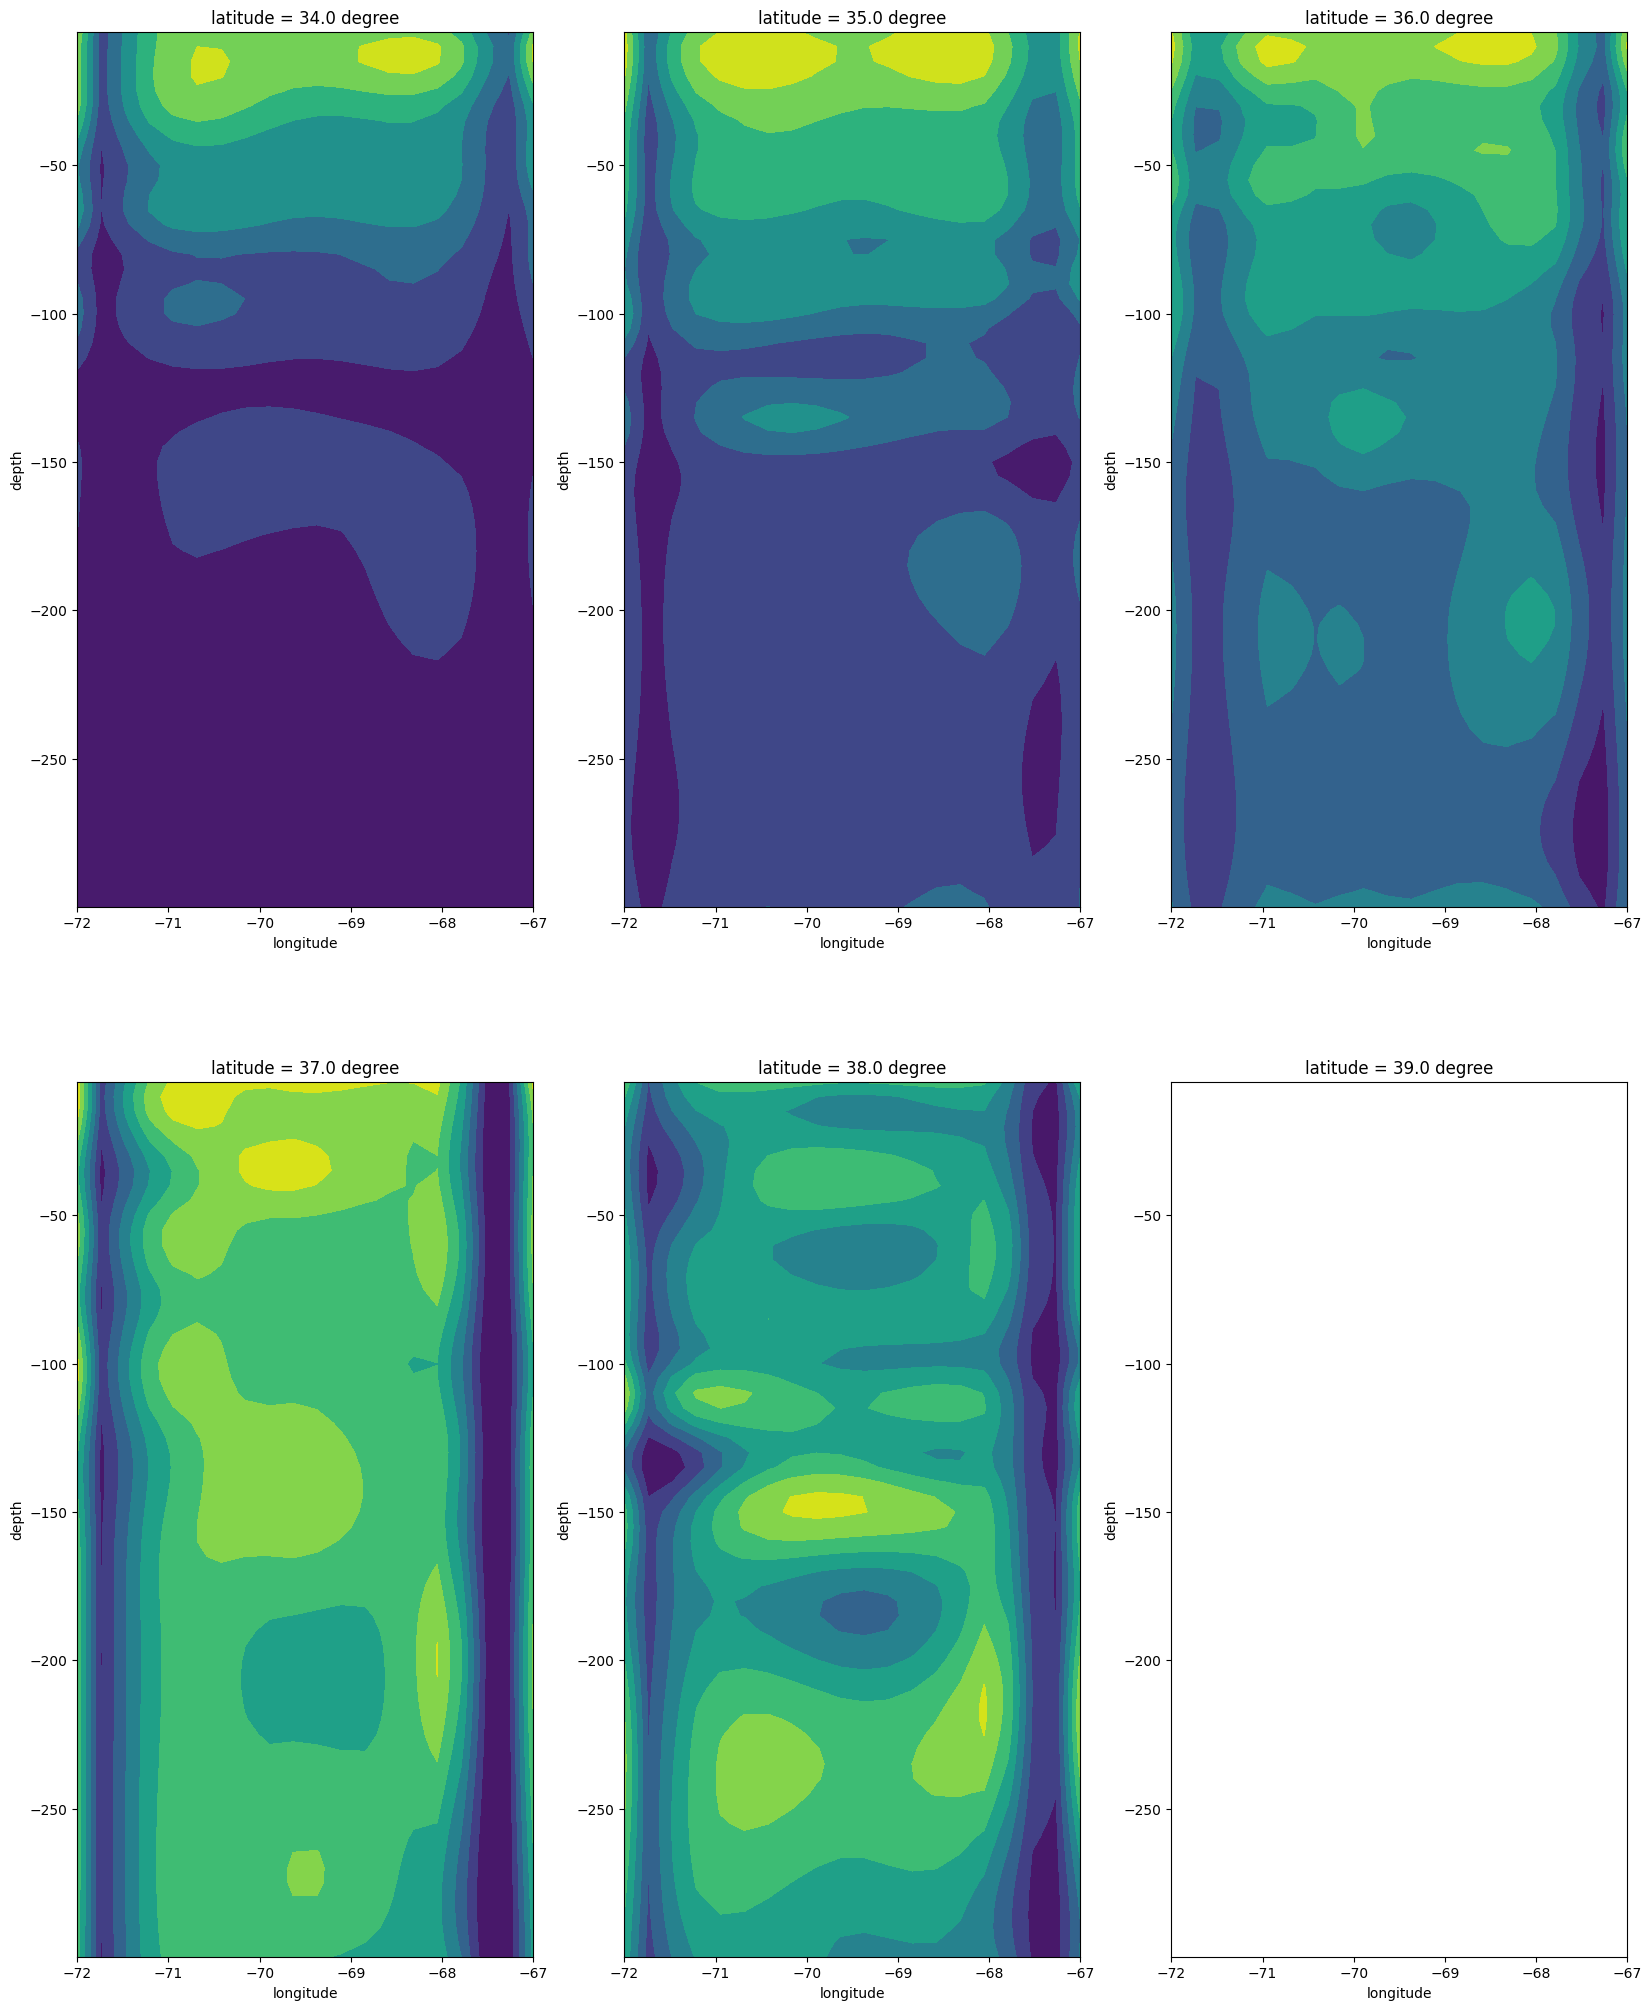

In [16]:
#plot vertical speed profile
plt.figure()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,25))

ax[0,0].contourf(lon_new, -dep_new, vertical_speed_over_latitude_layers_interpolated[0])
ax[0,0].set_title('latitude = ' + str(lat[0]) + ' degree')
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('depth')

ax[0,1].contourf(lon_new, -dep_new, vertical_speed_over_latitude_layers_interpolated[1])
ax[0,1].set_title('latitude = ' + str(lat[1]) + ' degree')
ax[0,1].set_xlabel('longitude')
ax[0,1].set_ylabel('depth')

ax[0,2].contourf(lon_new, -dep_new, vertical_speed_over_latitude_layers_interpolated[2])
ax[0,2].set_title('latitude = ' + str(lat[2]) + ' degree')
ax[0,2].set_xlabel('longitude')
ax[0,2].set_ylabel('depth')

ax[1,0].contourf(lon_new, -dep_new, vertical_speed_over_latitude_layers_interpolated[3])
ax[1,0].set_title('latitude = ' + str(lat[3]) + ' degree')
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('depth')

ax[1,1].contourf(lon_new, -dep_new, vertical_speed_over_latitude_layers_interpolated[4])
ax[1,1].set_title('latitude = ' + str(lat[4]) + ' degree')
ax[1,1].set_xlabel('longitude')
ax[1,1].set_ylabel('depth')

ax[1,2].contourf(lon_new, -dep_new, vertical_speed_over_latitude_layers_interpolated[5])
ax[1,2].set_title('latitude = ' + str(lat[5]) + ' degree')
ax[1,2].set_xlabel('longitude')
ax[1,2].set_ylabel('depth')

plt.savefig('myfile.png')